# Identifying Heat Waves

Heat Waves and how people experience heat can be influenced by a number of variables. The most obvious being the absolute temperature, but humidity and the duration of an extreme event can also be important factors. 

In [1]:
import intake
from pathlib import Path
import xarray as xr
import dask
import numpy as np
import pandas as pd

In [2]:
catalog = intake.open_catalog(Path(Path.home(),'heat_center/data/climate/reanalysis/intake/reanalysis.yaml'))

In [3]:
list(catalog['ERA5-Land']['day'])

['pev',
 'tasdp',
 'e',
 'pr',
 'ro',
 'ssrd',
 'tas',
 'uas',
 'tasmin',
 'vas',
 'ps',
 'tasmax']

In [4]:
catalog['ERA5-Land']['day']['tasmax'].to_dask()

ERROR 1: PROJ: proj_create_from_database: Open of /share/apps/anaconda3-2022.05/envs/pangeo/share/proj failed


<xarray.Dataset>
Dimensions:    (latitude: 741, longitude: 721, time: 26511, bnds: 2)
Coordinates:
  * latitude   (latitude) float32 38.0 37.9 37.8 37.7 ... -35.8 -35.9 -36.0
  * longitude  (longitude) float32 -20.0 -19.9 -19.8 -19.7 ... 51.8 51.9 52.0
  * time       (time) datetime64[ns] 1950-01-01T12:00:00 ... 2022-08-01
Dimensions without coordinates: bnds
Data variables:
    tasmax     (time, latitude, longitude) float32 dask.array<chunksize=(1, 741, 721), meta=np.ndarray>
    time_bnds  (time, bnds) datetime64[ns] dask.array<chunksize=(1, 2), meta=np.ndarray>
Attributes:
    CDI:          Climate Data Interface version 1.9.7.1 (http://mpimet.mpg.d...
    CDO:          Climate Data Operators version 1.9.7.1 (http://mpimet.mpg.d...
    Conventions:  CF-1.6
    NCO:          4.6.7
    frequency:    day
    history:      Thu Nov 10 11:18:23 2022: ncrename -v tas,tasmax ../../rean...

In [4]:
lat_ = -26.198513
lon_ = 28.029066

In [5]:
variables = ['tasmax','tasdp','tas','tasmin']

In [6]:
datasets_to_merge = []
for var in variables:
    ds = catalog['ERA5-Land']['day'][var].to_dask()
    ds = ds.sel(latitude = lat_,longitude = lon_, method = 'nearest')
    ds = ds.sel(time = slice('2000-01-01', '2020-12-31'))
    ds = ds[[var]] - 273.15
    datasets_to_merge.append(ds)

ERROR 1: PROJ: proj_create_from_database: Open of /share/apps/anaconda3-2022.05/envs/pangeo/share/proj failed


In [7]:
ds = xr.merge(datasets_to_merge)

In [8]:
ds

<xarray.Dataset>
Dimensions:    (time: 7671)
Coordinates:
    latitude   float32 -26.2
    longitude  float32 28.0
  * time       (time) datetime64[ns] 2000-01-01T11:30:00 ... 2020-12-31T11:30:00
Data variables:
    tasmax     (time) float32 dask.array<chunksize=(1,), meta=np.ndarray>
    tasdp      (time) float32 dask.array<chunksize=(1,), meta=np.ndarray>
    tas        (time) float32 dask.array<chunksize=(1,), meta=np.ndarray>
    tasmin     (time) float32 dask.array<chunksize=(1,), meta=np.ndarray>
Attributes:
    CDI:          Climate Data Interface version 1.9.7.1 (http://mpimet.mpg.d...
    CDO:          Climate Data Operators version 1.9.7.1 (http://mpimet.mpg.d...
    Conventions:  CF-1.6
    NCO:          4.6.7
    frequency:    day
    history:      Thu Nov 10 11:18:23 2022: ncrename -v tas,tasmax ../../rean...

In [9]:
import matplotlib.pyplot as plt

A quick sneak peak at the data:

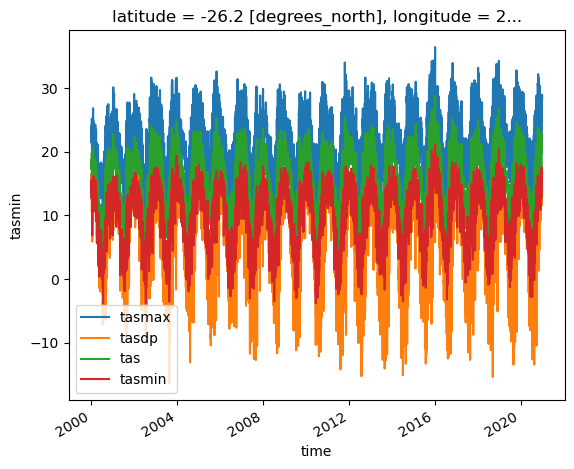

In [10]:
fig, ax = plt.subplots(ncols=1, nrows=1)

for var in variables:
    ds[var].plot(ax = ax, label = str(var))
    
ax.legend()

Considering a single month might be more digestible:

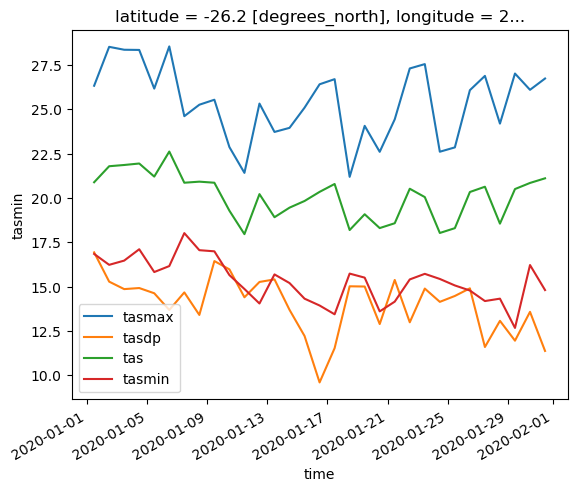

In [11]:
ds_ = ds.sel(time = slice('2020-01-01', '2020-01-31'))

fig, ax = plt.subplots(ncols=1, nrows=1)

for var in variables:
    ds_[var].plot(ax = ax, label = str(var))
    
ax.legend()

Identify days above where temperature exceeds the 99th percentile: 

In [12]:
ds = ds[['tasmax']]
ds = ds.load()

In [13]:
threshold = ds.tasmax.quantile(0.99, dim = 'time').values
threshold

array(31.27469788)

How many days per year exceed this threshold:

<AxesSubplot: xlabel='time'>

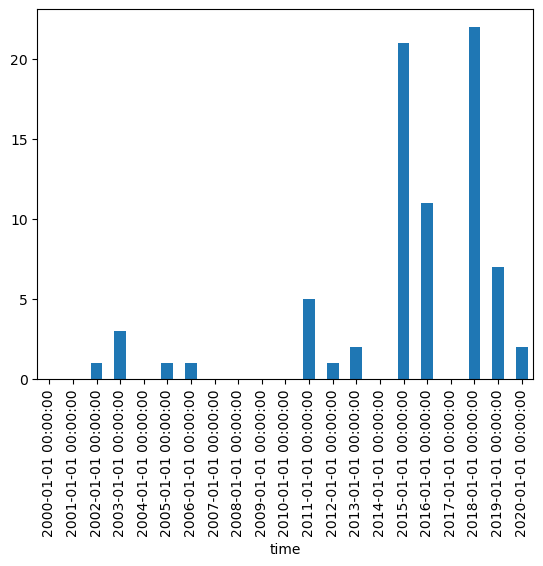

In [14]:
ds_extreme = ds.where(ds.tasmax >= threshold).tasmax
ds_extreme = ds_extreme/ds_extreme #this is a quick and dirty way to set all days above the threshold to 1, others become NAN
ds_extreme.resample(time = 'AS').sum().to_pandas().plot.bar()

There Certainly appears to be some years were extreme heat is more common. The duration of a heat event is however also important. Let's identify events where it temperature exceeds the 95th percentile for 5 days or longer:

In [15]:
threshold = ds.tasmax.quantile(0.95, dim = 'time').values
threshold

array(29.11569214)

In [16]:
ds['threshold'] = ds.where(ds.tasmax >= threshold).tasmax.fillna(0) #set days below 30 to 0
ds['threshold'] = ds.threshold/ds.threshold 

In [17]:
df = ds.threshold.to_pandas()

In [18]:
# Convert to sparse then query index to find block locations
sparse_df = df.astype(pd.SparseDtype('float'))
# we need to use .values.sp_index.to_block_index() in this version of pandas
block_locs = zip(
    sparse_df.values.sp_index.to_block_index().blocs,
    sparse_df.values.sp_index.to_block_index().blengths,
)
# Map the sparse blocks back to the dense timeseries
blocks = [
    df.iloc[start : (start + length - 1)]
    for (start, length) in block_locs
]

In [19]:
events = []
for block in blocks:
    if len(block) > 0:
        events.append([block.index[0], block.index[-1], len(block)])

In [20]:
df = pd.DataFrame(events)
df.columns = ['start', 'end', 'duration']

In [21]:
events = df.where(df.duration >= 5).dropna()

In [22]:
events

,start,end,duration
5,2003-12-10 11:30:00,2003-12-17 11:30:00,8.0
15,2007-02-19 11:30:00,2007-02-24 11:30:00,6.0
26,2011-11-08 11:30:00,2011-11-12 11:30:00,5.0
45,2015-10-04 11:30:00,2015-10-13 11:30:00,10.0
47,2015-11-07 11:30:00,2015-11-14 11:30:00,8.0
52,2015-12-17 11:30:00,2015-12-24 11:30:00,8.0
61,2016-10-27 11:30:00,2016-11-01 11:30:00,6.0
76,2018-11-11 11:30:00,2018-11-18 11:30:00,8.0
78,2018-12-13 11:30:00,2018-12-19 11:30:00,7.0
85,2019-10-15 11:30:00,2019-10-21 11:30:00,7.0


there are 10 events:

In [23]:
len(events)

10

Let's plot the temperature over these events (and two days before and after)

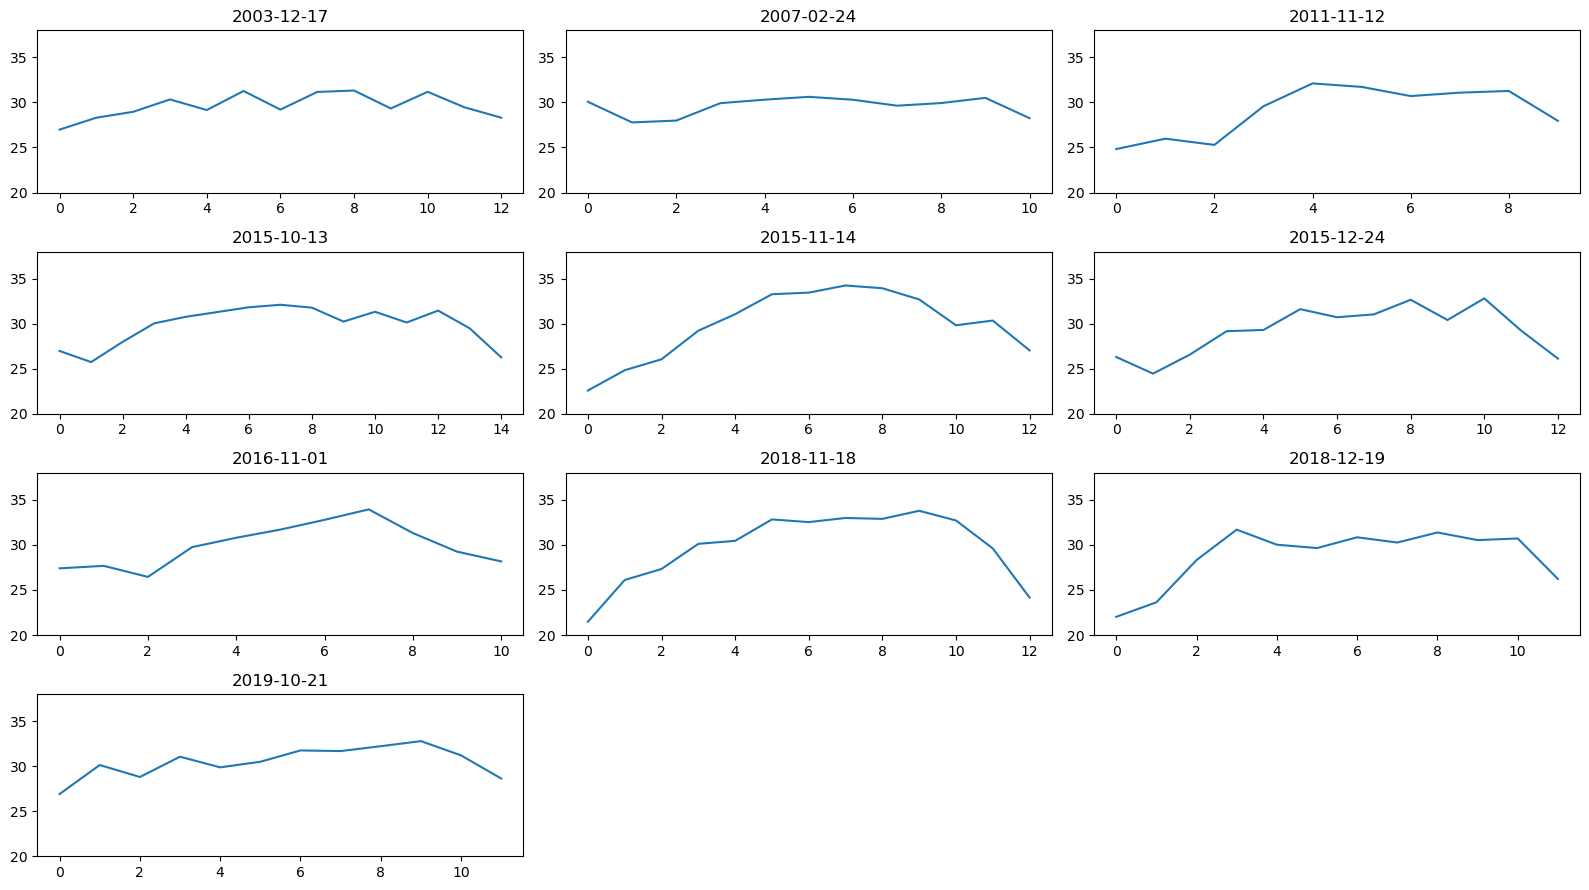

In [24]:
event_end_times = list(events.end.values)
event_length = list(events.duration.values)

fig, axes = plt.subplots(ncols=3, nrows=int(len(event_end_times)/3)+1, figsize=(16, 9))

for i,ax in enumerate(axes.flatten()):
    try:
        ax.plot(ds.tasmax.sel(time = slice(event_end_times[i] - np.timedelta64(int(event_length[i] +2), 'D'),event_end_times[i] + np.timedelta64(2, 'D'))))
        ax.set_ylim(20,38)
        #ax.get_xaxis().set_ticks([])
        ax.set_title(str(event_end_times[i])[:10])
    except:
        ax.set_axis_off()
        pass
    
plt.tight_layout()
plt.show()

Not particlarly interesting, maybe the hourly data could reveal more?

In [25]:
ds_1hr = catalog['ERA5-Land']['1hr']['tas'].to_dask()
ds_1hr = ds_1hr.sel(latitude = lat_,longitude = lon_, method = 'nearest')
ds_1hr = ds_1hr.sel(time = slice('2000-01-01', '2020-12-31'))
ds_1hr = ds_1hr[['tas']] - 273.15

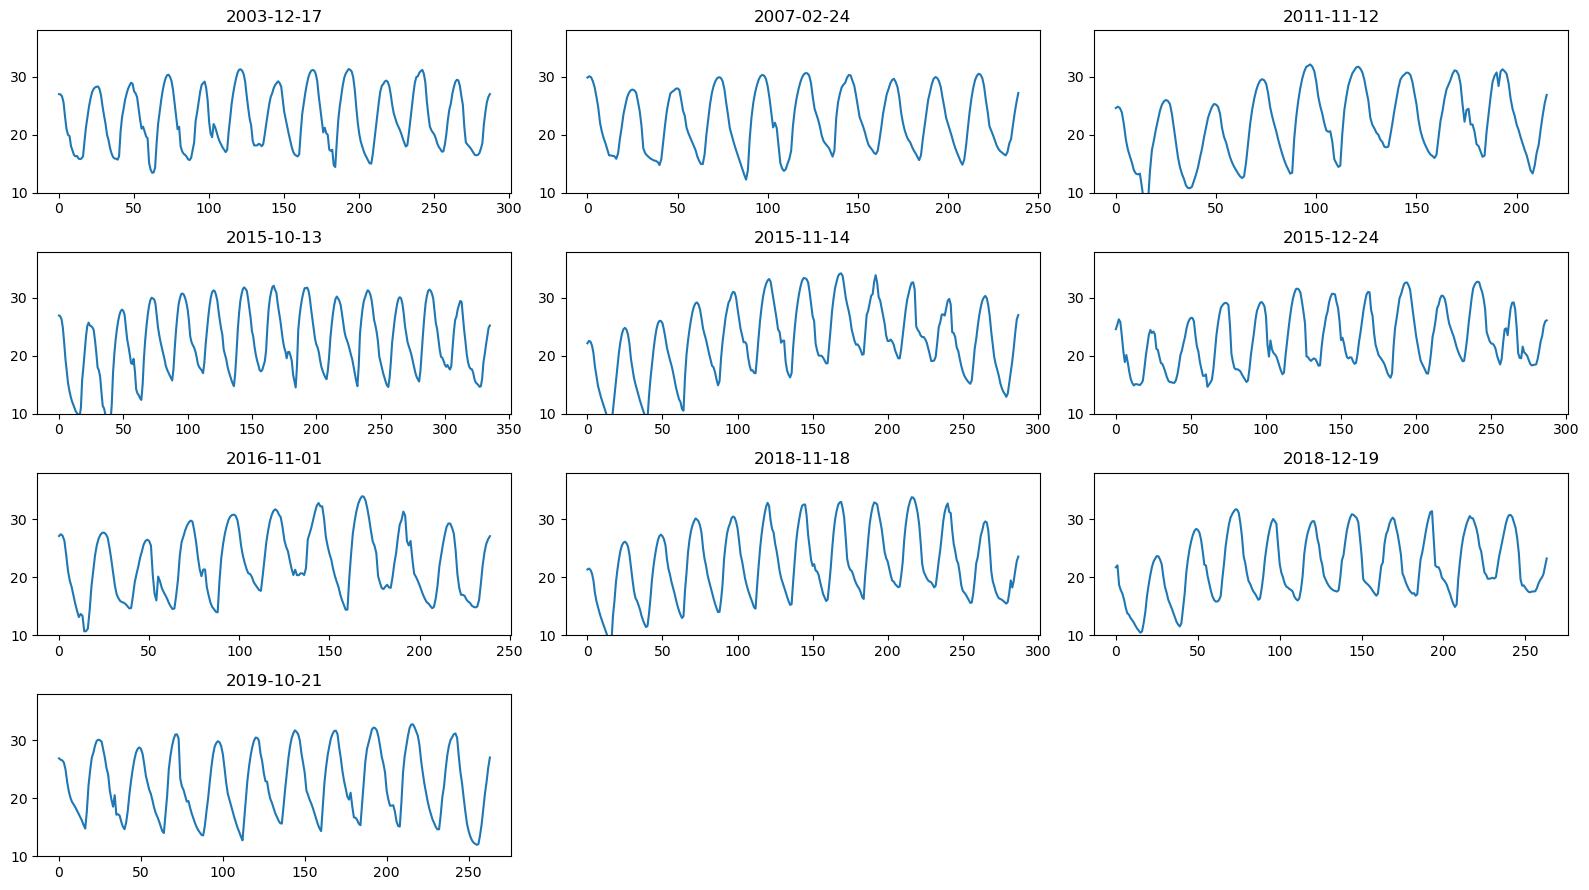

In [26]:
fig, axes = plt.subplots(ncols=3, nrows=int(len(event_end_times)/3)+1, figsize=(16, 9))

for i,ax in enumerate(axes.flatten()):
    try:
        ax.plot(ds_1hr.tas.sel(time = slice(event_end_times[i] - np.timedelta64(int(event_length[i]+2), 'D'),event_end_times[i] + np.timedelta64(2, 'D'))))
        ax.set_ylim(10,38)
        #ax.get_xaxis().set_ticks([])
        ax.set_title(str(event_end_times[i])[:10])
    except:
        ax.set_axis_off()
        pass
    
plt.tight_layout()
plt.show()

Also not much to be gained from this I suppose.

We know the event which started on the 2015-10-04 had the longest duration, but which was the most severe? Perhaps considering the average temperature across the duration of the event will give a different answer:

In [27]:
total_heat = []
average_heat = []
for i in range(len(event_end_times)):
    ds_heat_sel = ds_1hr.tas.sel(time = slice(event_end_times[i] - np.timedelta64(int(event_length[i]), 'D'),event_end_times[i]))
    total_heat.append(float(ds_heat_sel.sum().values))
    average_heat.append(float(ds_heat_sel.mean().values))

In [28]:
events['total_heat'] = total_heat
events['average_heat'] = average_heat

Unsurprisingly the longer heat events have a higher total heat value:

In [29]:
events.sort_values('total_heat', ascending = False)

,start,end,duration,total_heat,average_heat
45,2015-10-04 11:30:00,2015-10-13 11:30:00,10.0,5626.256836,23.442738
47,2015-11-07 11:30:00,2015-11-14 11:30:00,8.0,4712.777344,24.545715
76,2018-11-11 11:30:00,2018-11-18 11:30:00,8.0,4536.478027,23.627489
52,2015-12-17 11:30:00,2015-12-24 11:30:00,8.0,4509.367676,23.486290
5,2003-12-10 11:30:00,2003-12-17 11:30:00,8.0,4443.700195,23.144272
85,2019-10-15 11:30:00,2019-10-21 11:30:00,7.0,3835.725098,22.831697
78,2018-12-13 11:30:00,2018-12-19 11:30:00,7.0,3826.709473,22.778032
61,2016-10-27 11:30:00,2016-11-01 11:30:00,6.0,3419.571289,23.747023
15,2007-02-19 11:30:00,2007-02-24 11:30:00,6.0,3270.656006,22.712889
26,2011-11-08 11:30:00,2011-11-12 11:30:00,5.0,2753.257324,22.943811


But the average heat experienced across events is more interesting:

In [30]:
events.sort_values('average_heat', ascending = False)

,start,end,duration,total_heat,average_heat
47,2015-11-07 11:30:00,2015-11-14 11:30:00,8.0,4712.777344,24.545715
61,2016-10-27 11:30:00,2016-11-01 11:30:00,6.0,3419.571289,23.747023
76,2018-11-11 11:30:00,2018-11-18 11:30:00,8.0,4536.478027,23.627489
52,2015-12-17 11:30:00,2015-12-24 11:30:00,8.0,4509.367676,23.486290
45,2015-10-04 11:30:00,2015-10-13 11:30:00,10.0,5626.256836,23.442738
5,2003-12-10 11:30:00,2003-12-17 11:30:00,8.0,4443.700195,23.144272
26,2011-11-08 11:30:00,2011-11-12 11:30:00,5.0,2753.257324,22.943811
85,2019-10-15 11:30:00,2019-10-21 11:30:00,7.0,3835.725098,22.831697
78,2018-12-13 11:30:00,2018-12-19 11:30:00,7.0,3826.709473,22.778032
15,2007-02-19 11:30:00,2007-02-24 11:30:00,6.0,3270.656006,22.712889


### ERA5-HEAT is also available

ERA5-HEAT provides a complete historical reconstruction for a set of indices representing human thermal stress and discomfort in outdoor conditions. ERA5-HEAT (Human thErmAl comforT) represents the current state-of-the-art for bioclimatology data record production.

The dataset is organised around two main variables:

- the mean radiant temperature (MRT)
- the universal thermal climate index (UTCI)

These variables describe how the human body experiences atmospheric conditions, specifically air temperature, humidity, ventilation and radiation.

The dataset is computed using the ERA5 reanalysis from the European Centre for Medium-Range Forecasts (ECMWF). ERA5 combines model data with observations from across the world to provide a globally complete and consistent description of the Earth’s climate and its evolution in recent decades. ERA5 is regarded as a good proxy for observed atmospheric conditions.

For interest sake UTCI is calculated as a function of:
- Surface Wind Stress
- Temperature at 2m
- Dew Point Temperature at 2m (a function of humidity)
- Mean Radiant Temperature (MRT)

While MRT is a funciton of:
- surface solar radiation downwards
- surface net solar radiation
- direct radiation from the Sun
- Surface thermal radiation downwards
- Total sky direct solar radiation at surface
- Surface net thermal radiation
- cosine of solar zenith angle (function of latitude and time)

Of all these variable only Total sky direct solar radiation at surface (which incorporates the influence of clouds) is not available in ERA5-Land, hence why ERA5-HEAT is only available at the lower 0.25x0.25 degree resolution of ERA5. 

In [31]:
list(catalog['ERA5-HEAT']['1hr'])

['MRT', 'UTCI']

In [33]:
datasets_to_merge = []
for var in list(catalog['ERA5-HEAT']['1hr']):
    ds = catalog['ERA5-HEAT']['1hr'][var].to_dask()
    ds = ds.sel(lat = lat_,lon = lon_, method = 'nearest')
    ds = ds.sel(time = slice('2000-01-01', '2020-12-31'))
    ds = ds[[var]]
    datasets_to_merge.append(ds)

In [38]:
ds_HEAT = xr.merge(datasets_to_merge) 

In [41]:
ds_HEAT

<xarray.Dataset>
Dimensions:  (time: 184104)
Coordinates:
  * time     (time) datetime64[ns] 2000-01-01 ... 2020-12-31T23:00:00
    lat      float64 -26.25
    lon      float64 28.0
Data variables:
    MRT      (time) float32 dask.array<chunksize=(1,), meta=np.ndarray>
    UTCI     (time) float32 dask.array<chunksize=(1,), meta=np.ndarray>
Attributes:
    CDI:                       Climate Data Interface version 1.9.7.1 (http:/...
    CDO:                       Climate Data Operators version 1.9.7.1 (http:/...
    Conventions:               CF-1.6
    NCO:                       4.6.7
    cdo_openmp_thread_number:  8
    history:                   Thu Oct 20 13:01:57 2022: ncrename -v .MRTmax,...
    institution:               European Centre for Medium-Range Weather Forec...

As an experiment let's compare the average UTCI and MRT during the previously computed extreme heat events.

In [43]:
average_UTCI = []
average_MRT = []
for i in range(len(event_end_times)):
    ds_heat_sel = ds_HEAT.sel(time = slice(event_end_times[i] - np.timedelta64(int(event_length[i]), 'D'),event_end_times[i]))
    average_UTCI.append(float(ds_heat_sel.UTCI.mean().values))
    average_MRT.append(float(ds_heat_sel.MRT.mean().values))

In [44]:
events['average_UTCI'] = average_UTCI
events['average_MRT'] = average_MRT

In [45]:
events.sort_values('average_UTCI', ascending = False)

,start,end,duration,total_heat,average_heat,average_UTCI,average_MRT
52,2015-12-17 11:30:00,2015-12-24 11:30:00,8.0,4509.367676,23.486290,294.905823,304.305420
78,2018-12-13 11:30:00,2018-12-19 11:30:00,7.0,3826.709473,22.778032,294.802063,303.456390
76,2018-11-11 11:30:00,2018-11-18 11:30:00,8.0,4536.478027,23.627489,294.773346,303.091339
61,2016-10-27 11:30:00,2016-11-01 11:30:00,6.0,3419.571289,23.747023,294.633270,302.472961
47,2015-11-07 11:30:00,2015-11-14 11:30:00,8.0,4712.777344,24.545715,294.222992,302.952271
15,2007-02-19 11:30:00,2007-02-24 11:30:00,6.0,3270.656006,22.712889,294.080841,301.531708
85,2019-10-15 11:30:00,2019-10-21 11:30:00,7.0,3835.725098,22.831697,293.777161,301.045624
26,2011-11-08 11:30:00,2011-11-12 11:30:00,5.0,2753.257324,22.943811,293.687805,302.439545
5,2003-12-10 11:30:00,2003-12-17 11:30:00,8.0,4443.700195,23.144272,293.245728,302.744537
45,2015-10-04 11:30:00,2015-10-13 11:30:00,10.0,5626.256836,23.442738,292.956146,301.295502


In [46]:
events.sort_values('average_MRT', ascending = False)

,start,end,duration,total_heat,average_heat,average_UTCI,average_MRT
52,2015-12-17 11:30:00,2015-12-24 11:30:00,8.0,4509.367676,23.486290,294.905823,304.305420
78,2018-12-13 11:30:00,2018-12-19 11:30:00,7.0,3826.709473,22.778032,294.802063,303.456390
76,2018-11-11 11:30:00,2018-11-18 11:30:00,8.0,4536.478027,23.627489,294.773346,303.091339
47,2015-11-07 11:30:00,2015-11-14 11:30:00,8.0,4712.777344,24.545715,294.222992,302.952271
5,2003-12-10 11:30:00,2003-12-17 11:30:00,8.0,4443.700195,23.144272,293.245728,302.744537
61,2016-10-27 11:30:00,2016-11-01 11:30:00,6.0,3419.571289,23.747023,294.633270,302.472961
26,2011-11-08 11:30:00,2011-11-12 11:30:00,5.0,2753.257324,22.943811,293.687805,302.439545
15,2007-02-19 11:30:00,2007-02-24 11:30:00,6.0,3270.656006,22.712889,294.080841,301.531708
45,2015-10-04 11:30:00,2015-10-13 11:30:00,10.0,5626.256836,23.442738,292.956146,301.295502
85,2019-10-15 11:30:00,2019-10-21 11:30:00,7.0,3835.725098,22.831697,293.777161,301.045624


So interestingly the most severe event from a human experience point of view was the 2015-12-17 event, whilst the 2015-11-07 event had the highest absolute temperature.